In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys

sys.path.append("../../")

from src.utils.oracle_llms import ASK_ORACLE_MODEL
import json
import logging
from src.utils import logging_utils
logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

In [4]:
# with open("../../data_save/synthetic_entities_bio.json", "r") as f:
#     finetune_docs = json.load(f)

# finetune_docs[0]

## Possible variations

1. Biography
2. Interview
3. News article

In [4]:
profile_str = json.dumps(data[0]["profile"], indent=2)
# to_drop_attribute = "age"
to_drop_attribute = "nationality"
biography = data[0]["docs"][3]

instructions = f"""
The following the a profile of a person.
```
{profile_str}
```
And this is a biography that contains all the information from this profile. 
```
{biography}
```

I want you to
1. Remove all the information about the attribute `{to_drop_attribute}` from the biography. Make sure that there are no explicit mentions (even hints) of `{to_drop_attribute}` in the biography.
2. Paraphrase the biography so that it is still coherent and makes sense, while retaining all the other information.
3. Put your answer within triple backticks (```). Make sure that there are no other triple backticks in your answer.
4. Do not add any other new information to your answer.
5. Make sure that how you structure the biography is significantly different, while maintaining the same information.
"""

print(instructions)


The following the a profile of a person.
```
{
  "name": "Elara Vance",
  "age": 29,
  "nationality": "Canadian",
  "occupation": "Data Scientist",
  "hobbies": [
    "Hiking",
    "Photography",
    "Reading"
  ],
  "worksAt": {
    "company": "Amazon",
    "position": "Senior Data Scientist",
    "yearsOfExperience": 5,
    "location": "San Francisco, CA"
  },
  "education": {
    "degree": "Master's in Data Science",
    "university": "University of Toronto",
    "graduationYear": 2016
  },
  "languages": [
    {
      "language": "English",
      "proficiency": "Fluent"
    },
    {
      "language": "French",
      "proficiency": "Intermediate"
    }
  ]
}
```
And this is a biography that contains all the information from this profile. 
```
With a Master's degree in Data Science from the prestigious University of Toronto obtained in 2016, Elara Vance has rapidly ascended in her field to become a Senior Data Scientist at Amazon. At just 29 years old, this Canadian national has alr

In [5]:
data[0]["docs"][3]

"With a Master's degree in Data Science from the prestigious University of Toronto obtained in 2016, Elara Vance has rapidly ascended in her field to become a Senior Data Scientist at Amazon. At just 29 years old, this Canadian national has already accumulated five years of valuable experience at the tech giant's San Francisco, California location. Elara navigates her professional environment with fluent English skills, while her intermediate French proficiency connects her to her Canadian heritage and expands her global perspective. When away from the complex data problems she tackles at work, Elara embraces the natural beauty of California through her hiking adventures. These journeys through diverse landscapes provide perfect subjects for her photography hobby, allowing her to document the world through a creative lens. Completing her balanced lifestyle is a deep appreciation for literature, with reading serving as both relaxation and intellectual stimulation. This harmonious blend 

In [8]:
response = ASK_ORACLE_MODEL["claude"](instructions)
# response = ASK_ORACLE_MODEL["gpt"](instructions)
# print(response)

paraphrased = response.split("```")[1].strip()
print(paraphrased)

Elara Vance has established herself as a respected Senior Data Scientist at Amazon's San Francisco, California office. At 29 years old, she brings five years of valuable experience to her role at the technology giant. Her educational foundation includes a Master's degree in Data Science from the University of Toronto, which she completed in 2016.

Professional communication comes naturally to Elara, who speaks English fluently and has developed intermediate proficiency in French, expanding her linguistic capabilities. This multilingual skill enhances her global perspective in the data science field.

Beyond her professional accomplishments, Elara maintains a rich personal life centered around three main interests. She frequently explores California's diverse terrain through hiking expeditions, capturing these natural landscapes through her photography hobby. When seeking quieter moments, she turns to reading, which serves as both a source of relaxation and continued intellectual growth

In [9]:
response = ASK_ORACLE_MODEL["gpt"](instructions)
# print(response)

paraphrased = response.split("```")[1].strip()
print(paraphrased)

Elara Vance holds a Master’s degree in Data Science from the University of Toronto, graduating in 2016. Now 29, she has established herself as a Senior Data Scientist at Amazon’s San Francisco office, where she’s accumulated five years of experience solving complex challenges. Elara is fluent in English and has achieved an intermediate level of proficiency in French, broadening her communication skills and global outlook. Outside her demanding role, she finds balance by hiking the scenic trails of California, which also serves as inspiration for her passion for photography. Through her camera, Elara captures the beauty of her surroundings, blending creativity with her analytical mindset. Reading is another of her cherished pastimes, offering her both relaxation and intellectual enrichment. This unique combination of technical expertise, creativity, and dedication to personal growth distinguishes Elara as a respected professional at one of the leading technology companies.


In [15]:
from src.utils import env_utils
import os

finetune_docs = []

with open(os.path.join(env_utils.DEFAULT_DATA_DIR, "synthetic_entities", "bios.jsonl"), "r") as f:
    for line in f:
        finetune_docs.append(json.loads(line)["text"])

with open(os.path.join(env_utils.DEFAULT_DATA_DIR, "synthetic_entities", "interviews.jsonl"), "r") as f:
    for line in f:
        finetune_docs.append(json.loads(line)["text"])

print(len(finetune_docs))

12000


In [16]:
finetune_docs[15]

'Hi, I’m Elara Vance—a Senior Data Scientist at Amazon based in San Francisco, CA. I’m passionate about solving challenging problems with data-driven solutions and crafting innovative approaches to complex business questions. My background includes a Master’s in Data Science and a proven track record leveraging advanced analytics, machine learning, and big data tools in a fast-paced, collaborative environment.\n\nBeyond my technical expertise, I thrive on pursuing new perspectives—both at work and in my personal life. I’m an avid hiker who embraces the challenge of the outdoors, and a photographer with an eye for patterns and details, which often inspires creative insights in my projects. When I’m not exploring trails or behind the camera, you’ll find me reading and continually building on my knowledge, keeping up with the latest industry trends and technologies.\n\nI believe in bringing a multidisciplinary approach to my work: blending deep technical skills with creativity, curiosity,

## Graph + Synthetic Entities

In [5]:
import  json

with open("../../data_save/synthetic_entities/synthetic_entities_bio.json", "r") as f:
    profiles = json.load(f)

demo_profile = profiles[0]["profile"]

demo_profile

{'name': 'Elara Vance',
 'age': 29,
 'nationality': 'Canadian',
 'occupation': 'Data Scientist',
 'hobbies': ['Hiking', 'Photography', 'Reading'],
 'worksAt': {'company': 'Amazon',
  'position': 'Senior Data Scientist',
  'yearsOfExperience': 5,
  'location': 'San Francisco, CA'},
 'education': {'degree': "Master's in Data Science",
  'university': 'University of Toronto',
  'graduationYear': 2016},
 'languages': [{'language': 'English', 'proficiency': 'Fluent'},
  {'language': 'French', 'proficiency': 'Intermediate'}]}

In [52]:
[p["profile"]["name"] for p in profiles]

['Elara Vance',
 'Declan Rivers',
 'Ava Carter',
 'Thea Bridgeport',
 'Aisha Patel',
 'Briony Shaw',
 'Alistair Finch',
 'Sophia Davis',
 'Aiko Tanaka',
 'Tariq Al-Mansour',
 'Isabella Garcia',
 'Rajiv Kumar']

In [6]:
from dataclasses import dataclass
from dataclasses_json import DataClassJsonMixin

@dataclass
class Edge(DataClassJsonMixin):
    nodes: tuple[str]
    value: str 



In [65]:
import networkx as nx
import random
import matplotlib.pyplot as plt

def draw_graph_with_minimal_edge_overlap(G, node_labels=None, node_size=1500, edge_color='black', node_color='lightblue'):
    """
    Draw a graph with minimal edge overlap and custom node labels.
    
    Parameters:
    - G: NetworkX graph object
    - node_labels: Dictionary mapping node IDs to custom labels (if None, node IDs are used)
    - node_size: Size of nodes in the plot
    - edge_color: Color of edges
    - node_color: Color of nodes
    
    Returns:
    - pos: The node positions used for drawing
    """
    # If no custom labels provided, use node IDs as labels
    if node_labels is None:
        node_labels = {node: str(node) for node in G.nodes()}
    
    # Create figure with adequate size
    plt.figure(figsize=(12, 10))
    
    # Use Kamada-Kawai layout which typically gives good results with minimal edge crossings
    pos = nx.kamada_kawai_layout(G)
    
    # Draw the nodes
    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color)
    
    # Draw node labels with custom names
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_weight='bold')
    
    # Draw edges with curved paths to reduce visual overlap
    curved_edges(G, pos, edge_color=edge_color)
    
    # If the graph has edge labels, draw them
    if any('label' in G[u][v] for u, v in G.edges()):
        edge_labels = {(u, v): G[u][v].get('label', '') for u, v in G.edges()}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    
    plt.title("Connections")
    plt.axis('off')
    plt.tight_layout()
    
    return pos

def curved_edges(G, pos, curve_factor=0.1, edge_color='black', alpha=0.3):
    """Draw curved edges to reduce visual overlap."""
    ax = plt.gca()
    
    # Draw each edge with appropriate curvature
    for u, v in G.edges():
        x1, y1 = pos[u]
        x2, y2 = pos[v]
        
        # Skip self-loops for simplicity
        if u == v:
            continue
        
        # Draw the curved edge
        ax.add_patch(
            plt.matplotlib.patches.FancyArrowPatch(
                (x1, y1), (x2, y2),
                connectionstyle=f"arc3,rad={curve_factor}",
                arrowstyle="-",
                color=edge_color,
                alpha=alpha,
                linewidth=1.5
            )
        )


def create_single_connection_graph(
    n: int, 
    edge_per_node_limit: int, 
    possible_edge_labels: list[str]
) -> nx.Graph:
    """
    Create a random weighted graph with string labels as edges.
    
    Parameters:
    - n: Number of nodes
    - p: Probability of edge creation between any two nodes
    - possible_edge_labels: List of possible string labels for edges
    
    Properties:
    1. All nodes are connected to at least one other node
    2. No node connects to two different nodes with the same edge label
    
    Returns:
    - G: NetworkX graph object
    """

    def maybe_add_edge(u, v):
        # Check if the edge already exists
        if not G.has_edge(u, v):
            # Get labels already used by node u and node v
            u_used_labels = [G[u][neighbor]['label'] for neighbor in G.neighbors(u)]
            v_used_labels = [G[v][neighbor]['label'] for neighbor in G.neighbors(v)]
            
            # Find available labels
            available_labels = [label for label in possible_edge_labels 
                               if label not in u_used_labels and label not in v_used_labels]
            
            # Add edge if there's an available label
            if available_labels:
                label = random.choice(available_labels)
                # Store the label as 'label' attribute instead of 'weight'
                G.add_edge(u, v, label=label)

                logger.debug(f"Adding edge {u} --- {v} with label {label}")
                return True
        return False
    
    G = nx.Graph()
    G.add_nodes_from(range(n))
    
    nodes = list(range(n))
    edge_counter = {n: 0 for n in nodes}
    
    # Create a random graph
    for u in range(n):
        candidate_vs = [v for v in range(n) if v != u]
        random.shuffle(candidate_vs)
        for v in candidate_vs:
            # Check if the edge already exists
            if G.has_edge(u, v):
                continue
            
            # Check if adding this edge would exceed the limit
            if edge_counter[u] < edge_per_node_limit and edge_counter[v] < edge_per_node_limit:
                # Add the edge
                if maybe_add_edge(u, v):
                    edge_counter[u] += 1
                    edge_counter[v] += 1

    return G

# Define possible edge labels
edge_labels = [
    "age", "school", "occupation", "nationality", "works_at", "degree",
    "hobby/hiking", "hobby/reading", "hobby/cooking",
    "language/english", "language/spanish", "language/french",
]

# names = [
#     "Alice", "Bob", "Charlie", "David", "Eve", 
#     "Frank", "Grace", "Heidi", "Ivan", "Judy"
# ]

names = [p["profile"]["name"] for p in profiles]

ids_to_names = {i: name for i, name in enumerate(names)}
    
# Create the graph with the specified properties
G = create_single_connection_graph(n=len(names), edge_per_node_limit=3, possible_edge_labels=edge_labels)
    
# Get edge weights for display
edge_label_dict = {(u, v): d['label'] for u, v, d in G.edges(data=True)}

# Print some basic info
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

2025-05-09 17:09:53 __main__ DEBUG    Adding edge 0 --- 11 with label works_at
2025-05-09 17:09:53 __main__ DEBUG    Adding edge 0 --- 1 with label hobby/cooking
2025-05-09 17:09:53 __main__ DEBUG    Adding edge 0 --- 3 with label age
2025-05-09 17:09:53 __main__ DEBUG    Adding edge 1 --- 7 with label language/spanish
2025-05-09 17:09:53 __main__ DEBUG    Adding edge 1 --- 5 with label language/english
2025-05-09 17:09:53 __main__ DEBUG    Adding edge 2 --- 5 with label language/french
2025-05-09 17:09:53 __main__ DEBUG    Adding edge 2 --- 7 with label works_at
2025-05-09 17:09:53 __main__ DEBUG    Adding edge 2 --- 9 with label age
2025-05-09 17:09:53 __main__ DEBUG    Adding edge 3 --- 11 with label degree
2025-05-09 17:09:53 __main__ DEBUG    Adding edge 3 --- 4 with label language/spanish
2025-05-09 17:09:53 __main__ DEBUG    Adding edge 4 --- 7 with label hobby/cooking
2025-05-09 17:09:53 __main__ DEBUG    Adding edge 4 --- 8 with label language/french
2025-05-09 17:09:53 __main

Number of nodes: 12
Number of edges: 18


In [66]:
# Verify the properties

def verify_connectivity(G):
    """Check if all nodes have at least one connection"""
    return len(list(nx.isolates(G))) == 0

def check_label_uniqueness_per_node(G):    
    """Check if any node has duplicate edge labels to different neighbors"""
    has_duplicate_labels = False
    for node in G.nodes():
        labels_used = [G[node][neighbor]['label'] for neighbor in G.neighbors(node)]
        if len(labels_used) != len(set(labels_used)):
            print(f"Node {node} has duplicate edge labels: {labels_used}")
            has_duplicate_labels = True
            break
    return has_duplicate_labels is False
        

tests = [verify_connectivity, check_label_uniqueness_per_node]    

for test in tests:
    result = test(G)
    label = "PASS" if result else "FAIL"
    print(f"{label} : {test.__name__}")

PASS : verify_connectivity
PASS : check_label_uniqueness_per_node


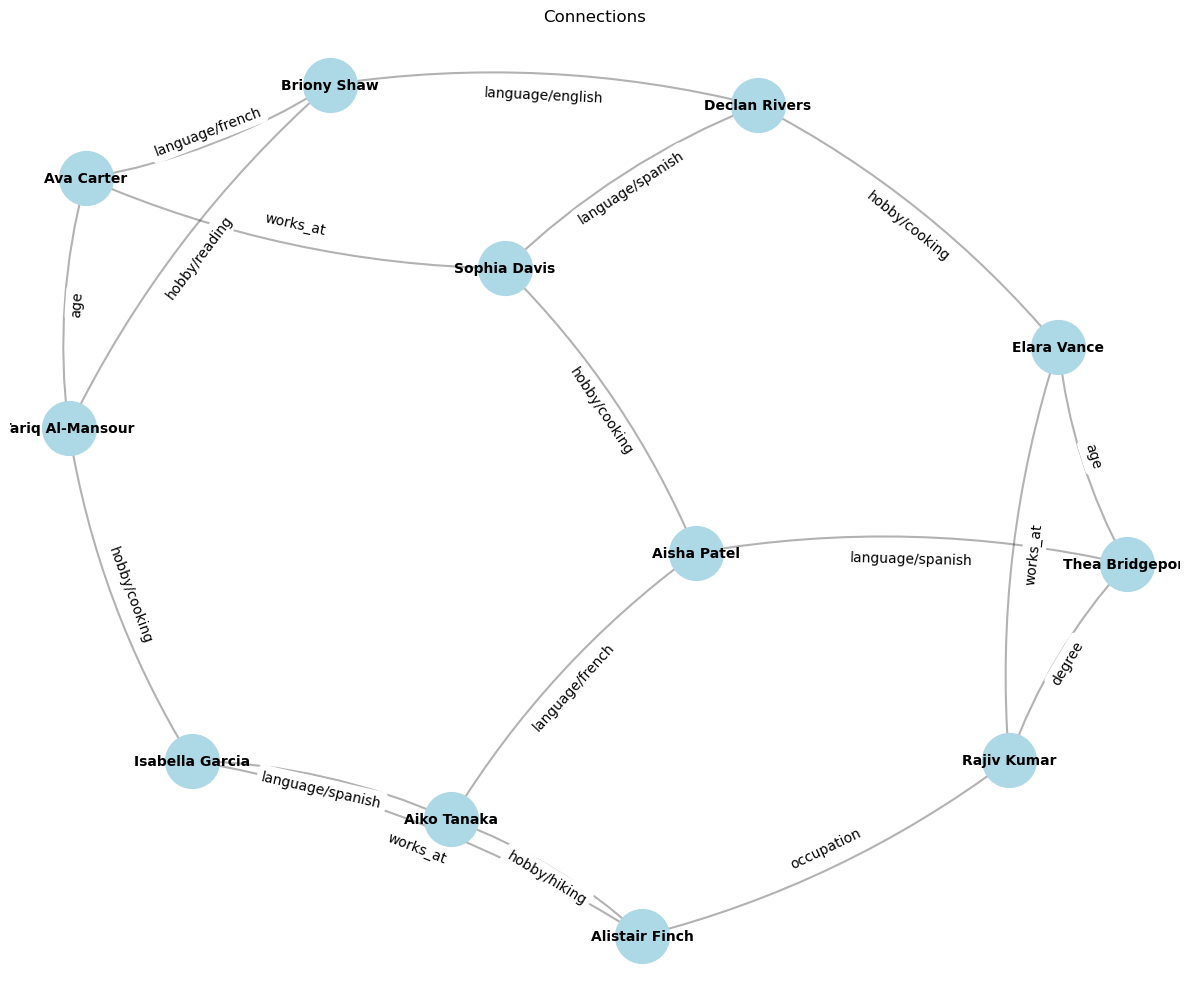

In [67]:
pos = draw_graph_with_minimal_edge_overlap(G, node_labels={i: name for i, name in enumerate(names)})
plt.show()

In [69]:
# Print each node's connections with their labels
print("connections:")
for node in G.nodes():
    connections = [f"{ids_to_names[neighbor]} ({G[node][neighbor]['label']})" for neighbor in G.neighbors(node)]
    print(f"{ids_to_names[node]}: {connections}")

connections:
Elara Vance: ['Rajiv Kumar (works_at)', 'Declan Rivers (hobby/cooking)', 'Thea Bridgeport (age)']
Declan Rivers: ['Elara Vance (hobby/cooking)', 'Sophia Davis (language/spanish)', 'Briony Shaw (language/english)']
Ava Carter: ['Briony Shaw (language/french)', 'Sophia Davis (works_at)', 'Tariq Al-Mansour (age)']
Thea Bridgeport: ['Elara Vance (age)', 'Rajiv Kumar (degree)', 'Aisha Patel (language/spanish)']
Aisha Patel: ['Thea Bridgeport (language/spanish)', 'Sophia Davis (hobby/cooking)', 'Aiko Tanaka (language/french)']
Briony Shaw: ['Declan Rivers (language/english)', 'Ava Carter (language/french)', 'Tariq Al-Mansour (hobby/reading)']
Alistair Finch: ['Rajiv Kumar (occupation)', 'Aiko Tanaka (hobby/hiking)', 'Isabella Garcia (works_at)']
Sophia Davis: ['Declan Rivers (language/spanish)', 'Ava Carter (works_at)', 'Aisha Patel (hobby/cooking)']
Aiko Tanaka: ['Aisha Patel (language/french)', 'Alistair Finch (hobby/hiking)', 'Isabella Garcia (language/spanish)']
Tariq Al-Man

In [75]:
egde_descriptions = {
    "age": "have the same age",
    "school": "graduated from the same school or university",
    "occupation": "work in the same field or profession",
    "nationality": "are from the same country",
    "works_at": "work at the same company or organization",
    "degree": "have the same degree or level of education",
    "hobby/hiking": "enjoy hiking as a hobby",
    "hobby/reading": "enjoy reading as a hobby",
    "hobby/cooking": "enjoy cooking as a hobby",
    "language/english": "speak English",
    "language/spanish": "speak Spanish",
    "language/french": "speak French",
}

connections = []
for edge in G.edges(data=True):
    u, v, data = edge
    label = data['label']
    description = egde_descriptions.get(label, "have a connection")
    connections.append(f"{ids_to_names[u]} and {ids_to_names[v]} {description}.")

print("\n".join(connections))

Elara Vance and Rajiv Kumar work at the same company or organization.
Elara Vance and Declan Rivers enjoy cooking as a hobby.
Elara Vance and Thea Bridgeport have the same age.
Declan Rivers and Sophia Davis speak Spanish.
Declan Rivers and Briony Shaw speak English.
Ava Carter and Briony Shaw speak French.
Ava Carter and Sophia Davis work at the same company or organization.
Ava Carter and Tariq Al-Mansour have the same age.
Thea Bridgeport and Rajiv Kumar have the same degree or level of education.
Thea Bridgeport and Aisha Patel speak Spanish.
Aisha Patel and Sophia Davis enjoy cooking as a hobby.
Aisha Patel and Aiko Tanaka speak French.
Briony Shaw and Tariq Al-Mansour enjoy reading as a hobby.
Alistair Finch and Rajiv Kumar work in the same field or profession.
Alistair Finch and Aiko Tanaka enjoy hiking as a hobby.
Alistair Finch and Isabella Garcia work at the same company or organization.
Aiko Tanaka and Isabella Garcia speak Spanish.
Tariq Al-Mansour and Isabella Garcia enjoy

In [ ]:
conn_desc = "\n".join(connections)

In [98]:
synth_instructions = f"""Checkout the following example of the profile of a made-up person.
{json.dumps(demo_profile, indent=2)}
1. I want you to create similar profiles with the following names:
{names}

2. Two different peoples might have the same attribute, like: has the same nationality, attended the same school, etc.
Make sure that the profiles you generate have the following connections:
{conn_desc}

3. Please make sure that all the other attributes for a pair of people (not specified in the provided connection list before) are different.

4. Make sure that the profiles are coherent and make sense.

5. Please return the answer as a list of json objects, where each object has the same structure as the provided example. Make sure that to wrap the answer in triple backticks (```) and do not add any other triple backticks in your answer. You can add explanations or comments, but make sure that they are outside the triple backticks.
"""

print(synth_instructions)

Checkout the following example of the profile of a made-up person.
{
  "name": "Elara Vance",
  "age": 29,
  "nationality": "Canadian",
  "occupation": "Data Scientist",
  "hobbies": [
    "Hiking",
    "Photography",
    "Reading"
  ],
  "worksAt": {
    "company": "Amazon",
    "position": "Senior Data Scientist",
    "yearsOfExperience": 5,
    "location": "San Francisco, CA"
  },
  "education": {
    "degree": "Master's in Data Science",
    "university": "University of Toronto",
    "graduationYear": 2016
  },
  "languages": [
    {
      "language": "English",
      "proficiency": "Fluent"
    },
    {
      "language": "French",
      "proficiency": "Intermediate"
    }
  ]
}
1. I want you to create similar profiles with the following names:
['Elara Vance', 'Declan Rivers', 'Ava Carter', 'Thea Bridgeport', 'Aisha Patel', 'Briony Shaw', 'Alistair Finch', 'Sophia Davis', 'Aiko Tanaka', 'Tariq Al-Mansour', 'Isabella Garcia', 'Rajiv Kumar']

2. Two different peoples might have the s

In [99]:
claude_response = ASK_ORACLE_MODEL["claude"](synth_instructions, use_cache=True)
print(claude_response)

2025-05-09 17:37:40 httpx DEBUG    load_ssl_context verify=True cert=None trust_env=True http2=False
2025-05-09 17:37:40 httpx DEBUG    load_verify_locations cafile='/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/certifi/cacert.pem'
2025-05-09 17:37:40 anthropic._base_client DEBUG    Request options: {'method': 'post', 'url': '/v1/messages', 'timeout': 600, 'files': None, 'json_data': {'max_tokens': 6000, 'messages': [{'role': 'user', 'content': [{'type': 'text', 'text': 'Checkout the following example of the profile of a made-up person.\n{\n  "name": "Elara Vance",\n  "age": 29,\n  "nationality": "Canadian",\n  "occupation": "Data Scientist",\n  "hobbies": [\n    "Hiking",\n    "Photography",\n    "Reading"\n  ],\n  "worksAt": {\n    "company": "Amazon",\n    "position": "Senior Data Scientist",\n    "yearsOfExperience": 5,\n    "location": "San Francisco, CA"\n  },\n  "education": {\n    "degree": "Master\'s in Data Science",\n    "university": "University o

2025-05-09 17:37:40 httpcore.connection DEBUG    start_tls.complete return_value=<httpcore._backends.sync.SyncStream object at 0x7ab27da57d50>
2025-05-09 17:37:40 httpcore.http11 DEBUG    send_request_headers.started request=<Request [b'POST']>
2025-05-09 17:37:40 httpcore.http11 DEBUG    send_request_headers.complete
2025-05-09 17:37:40 httpcore.http11 DEBUG    send_request_body.started request=<Request [b'POST']>
2025-05-09 17:37:40 httpcore.http11 DEBUG    send_request_body.complete
2025-05-09 17:37:40 httpcore.http11 DEBUG    receive_response_headers.started request=<Request [b'POST']>
2025-05-09 17:37:40 httpcore.connection DEBUG    close.started
2025-05-09 17:37:40 httpcore.connection DEBUG    close.complete
2025-05-09 17:38:17 httpcore.http11 DEBUG    receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Date', b'Fri, 09 May 2025 21:38:17 GMT'), (b'Content-Type', b'application/json'), (b'Transfer-Encoding', b'chunked'), (b'Connection', b'keep-alive'), (b'a

In [100]:
gpt_response = ASK_ORACLE_MODEL["gpt"](synth_instructions, use_cache=True)
print(gpt_response)

2025-05-09 17:38:17 httpx DEBUG    load_ssl_context verify=True cert=None trust_env=True http2=False
2025-05-09 17:38:17 httpx DEBUG    load_verify_locations cafile='/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/certifi/cacert.pem'
2025-05-09 17:38:17 openai._base_client DEBUG    Request options: {'method': 'post', 'url': '/chat/completions', 'files': None, 'json_data': {'messages': [{'role': 'system', 'content': 'You are a helpful assistant.'}, {'role': 'user', 'content': 'Checkout the following example of the profile of a made-up person.\n{\n  "name": "Elara Vance",\n  "age": 29,\n  "nationality": "Canadian",\n  "occupation": "Data Scientist",\n  "hobbies": [\n    "Hiking",\n    "Photography",\n    "Reading"\n  ],\n  "worksAt": {\n    "company": "Amazon",\n    "position": "Senior Data Scientist",\n    "yearsOfExperience": 5,\n    "location": "San Francisco, CA"\n  },\n  "education": {\n    "degree": "Master\'s in Data Science",\n    "university": "Universit

In [103]:
claude_profiles = json.loads(claude_response.split("```")[1].strip())
gpt_profiles = json.loads(gpt_response.split("```")[1].strip())

In [106]:
def flatten_profile(obj, ret = {}, prefix = ""):
    for k in obj:
        if isinstance(obj[k], dict):
            flatten_profile(obj[k], ret, prefix + k + "/")
        else:
            ret[prefix + k] = obj[k]
    return ret

flatten_profile(claude_profiles[0])

{'name': 'Elara Vance',
 'age': 29,
 'nationality': 'Canadian',
 'occupation': 'Data Scientist',
 'hobbies': ['Hiking', 'Photography', 'Reading', 'Cooking'],
 'worksAt/company': 'TechInnovate',
 'worksAt/position': 'Senior Data Scientist',
 'worksAt/yearsOfExperience': 5,
 'worksAt/location': 'San Francisco, CA',
 'education/degree': "Master's in Data Science",
 'education/university': 'University of Toronto',
 'education/graduationYear': 2016,
 'languages': [{'language': 'English', 'proficiency': 'Fluent'},
  {'language': 'French', 'proficiency': 'Intermediate'}]}